In [1]:
import pickle
import matplotlib.pyplot as plt
import adaptive_latents as al
import glob
import subprocess
import numpy as np
import time

In [2]:
switch_iteration = 270
subprocess.call(["python", "run_partial_start.py", "gpu", str(switch_iteration)])
subprocess.call(["python", "run_partial_start.py", "cpu", str(switch_iteration)])

# these are to compare e.g. "cpu" vs "cpu cpu"
subprocess.call(["python", "run_partial_start.py", "gpu", "None"])
subprocess.call(["python", "run_partial_start.py", "cpu", "None"])

subprocess.call(["python", "run_partial_finish.py", "gpu", "2"])
subprocess.call(["python", "run_partial_finish.py", "cpu", "4"])

0

In [3]:
files = sorted(glob.glob(f"{al.CONFIG["output_path"]/"bubblewrap_runs"}/*.pickle"))
brs = []
for file in files[-6:]:
    with open(file, 'br') as fhan:
        brs.append(pickle.load(fhan))
brs = np.array(brs)
brs = brs.reshape(-1,2)

240
246


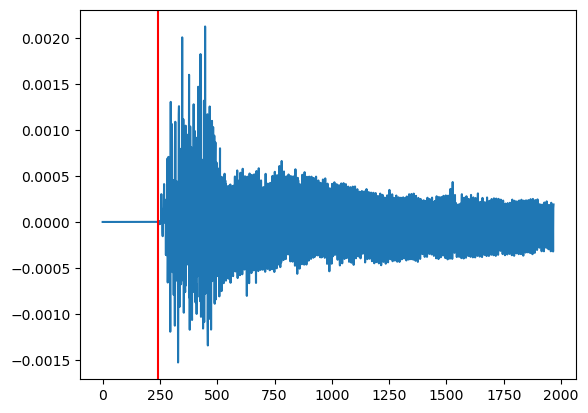

In [4]:
%matplotlib inline
plt.plot(brs[0,1].entropy_history[1] - brs[-1,1].entropy_history[1])
plt.axvline(switch_iteration-brs[0,0].bw.M, color='red')
print(switch_iteration - brs[0,0].bw.M)
print(np.nonzero(brs[0,1].entropy_history[1] - brs[-1,1].entropy_history[1] > 0)[0][0])

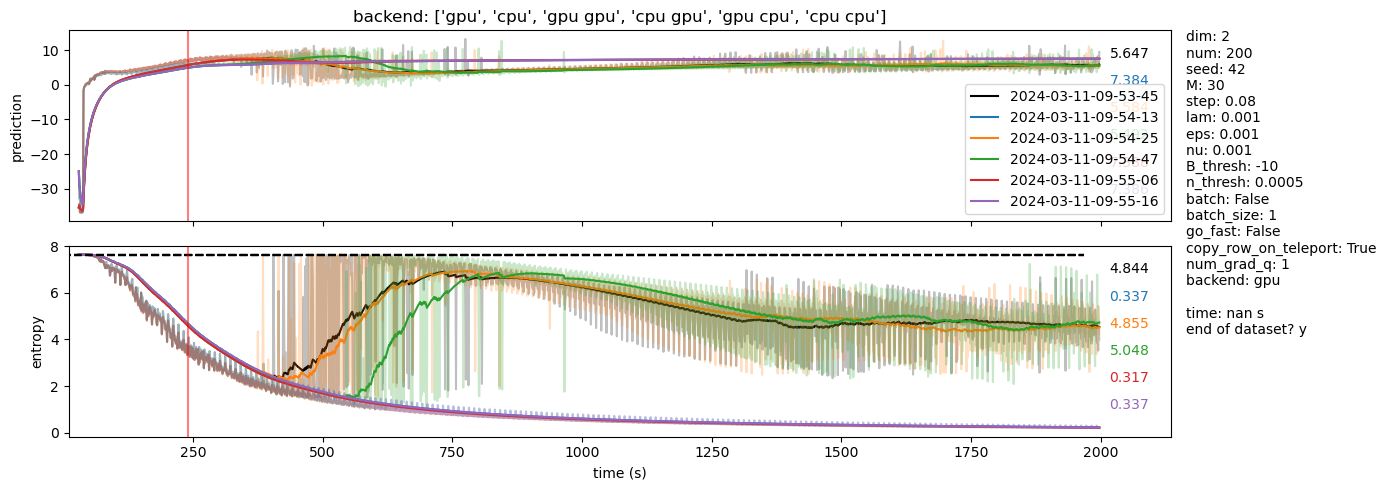

In [12]:
%matplotlib inline
# red_lines=[brs[0,0].obs_ds.t[switch_iteration]]
al.plotting_functions.compare_metrics(brs.flatten(), 1, red_lines=[brs[0,0].obs_ds.t[switch_iteration-brs[0,0].bw.M]])

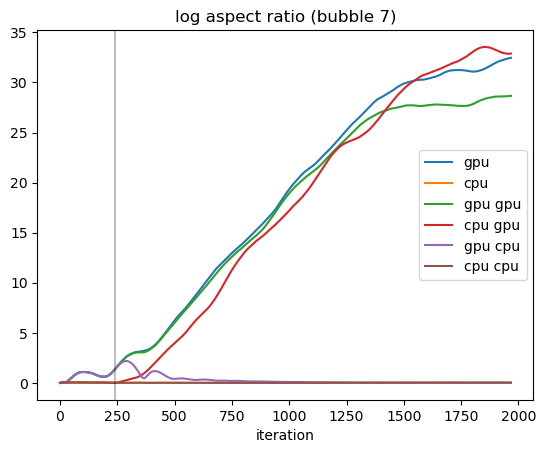

In [6]:
def show_aspect_ratio_divergence(brs, bubble=5, switch=250):
    fig,ax = plt.subplots()
    
    m = bubble
    for k in range(len(brs)):
        ratios = []
        for i in range(brs[k].L_history.shape[0]):
            L = brs[k].L_history[i,m,...]
            _, s, _= np.linalg.svd(np.linalg.pinv(L.T@L))
            ratios.append(s.max() / s.min())
        ratios = np.log(ratios)
        ax.plot(ratios, label=brs[k].bw.backend_note)
    
    ax.set_title(f"log aspect ratio (bubble {m})");
    ax.legend();
    ax.axvline(switch-brs[0].bw.M, color='k', alpha=.25);
    ax.set_xlabel("iteration");
show_aspect_ratio_divergence(brs.flatten(), bubble=7, switch=switch_iteration)

## Inspect a single switch

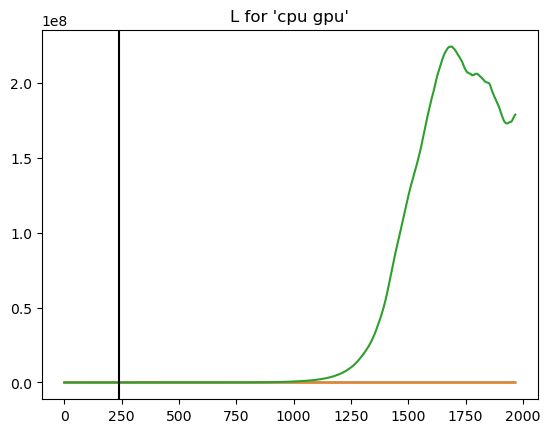

In [7]:
%matplotlib inline
br = brs[1][1]
dim = br.bw.mu.shape[1]

plt.plot((br.L_history[:,3,*np.tril_indices(dim, k=0)]))
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
# plt.ylim([0,900])
plt.title(f"L for '{br.bw.backend_note}'");

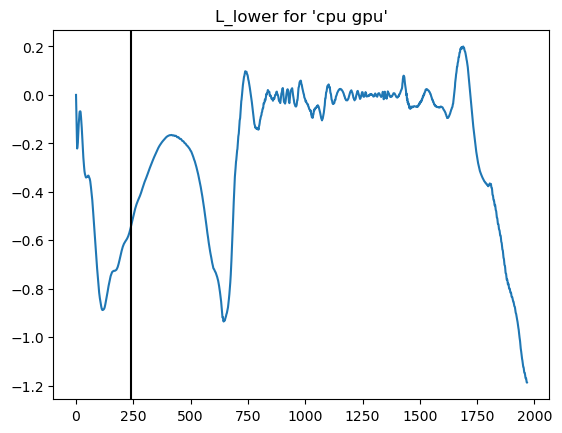

In [8]:
%matplotlib inline


plt.plot((br.L_lower_history[:,5,*np.tril_indices(dim, k=-1)]))
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
plt.title(f"L_lower for '{br.bw.backend_note}'");

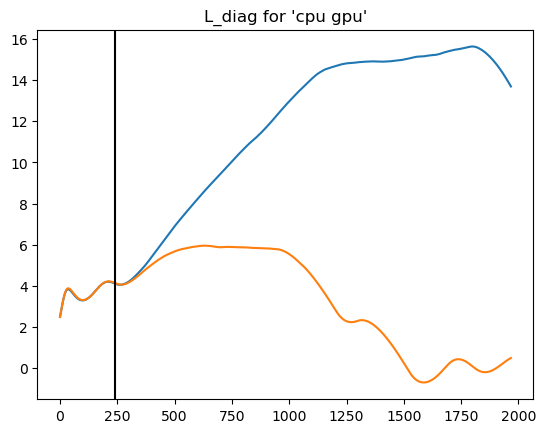

In [9]:
%matplotlib inline
dim = br.bw.mu.shape[1]

bubble=4
plt.plot((br.L_diag_history[:,bubble,...]))
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
plt.title(f"L_diag for '{br.bw.backend_note}'");

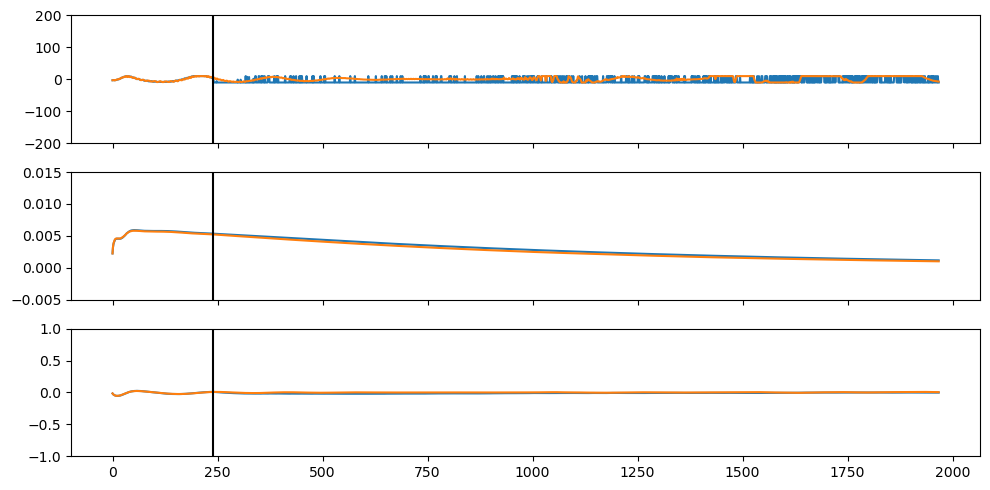

In [10]:
%matplotlib inline
fig, axs = plt.subplots(nrows=3, layout="tight", figsize=(10,5), sharex=True)

bubble = 5
axs[0].plot(br.L_diag_grad_history[:, bubble, :])
axs[0].set_ylim(np.array([-1,1])*200)

axs[1].plot(br.L_diag_v_history[:, bubble, :])
axs[1].set_ylim(np.array([-1,1])*.01 + 0.005)


axs[2].plot(br.L_diag_m_history[:, bubble, :])
axs[2].set_ylim(np.array([-1,1])*1)


for i in range(3):
    axs[i].axvline(switch_iteration - brs[0,0].bw.M, color='k')


In [10]:
%matplotlib qt
fig, axs = plt.subplots(nrows=3, layout="tight", figsize=(10,5), sharex=True)

bubble = 5
axs[0].plot(br.L_diag_grad_history[:, bubble, :])
axs[0].set_ylim(np.array([-1,1])*200)

axs[1].plot(br.L_diag_v_history[:, bubble, :])
axs[1].set_ylim(np.array([-1,1])*.01 + 0.005)


axs[2].plot(br.L_diag_m_history[:, bubble, :])
axs[2].set_ylim(np.array([-1,1])*1)


for i in range(3):
    axs[i].axvline(switch_iteration - brs[0,0].bw.M, color='k')


In [17]:
br.L_diag_grad_history[switch_iteration - brs[0,0].bw.M -10, bubble, :]

array([1.7157992e+08, 4.3703232e+00], dtype=float32)

In [22]:
L = br.L_history[-1][0]
L = np.linalg.inv(L)
L @ L.T

array([[ 8.5162337e-25, -5.3912339e-19],
       [-5.3912339e-19,  2.0953766e+07]], dtype=float32)

In [23]:
np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))

/tmp/ipykernel_8760/2102186140.py:1: RuntimeWarning: overflow encountered in exp
  np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))


array([[ 1.      ,  0.      ],
       [28.711327,  1.      ]], dtype=float32)

In [24]:
# 
L = np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))
el = np.linalg.inv(L)
el.T @ el

/tmp/ipykernel_8760/2669974581.py:2: RuntimeWarning: overflow encountered in exp
  L = np.tril(np.diag(np.exp(br.bw.L_lower[0]) + 1e-10) + np.tril(br.bw.L_diag[0], -1))


array([[825.3403  , -28.711327],
       [-28.711327,   1.      ]], dtype=float32)

In [11]:
br.L_history[-1,5,...]

array([[ 2.3634947e+01,  0.0000000e+00,  0.0000000e+00],
       [-5.3716103e+01,  2.1895750e+01,  0.0000000e+00],
       [ 3.0881435e+01, -3.5636208e+01,  3.2153568e+04]], dtype=float32)

/tmp/ipykernel_8760/2178579260.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(br.L_grad_history[:,5,...].reshape(-1,br.bw.mu.shape[1]**2))))


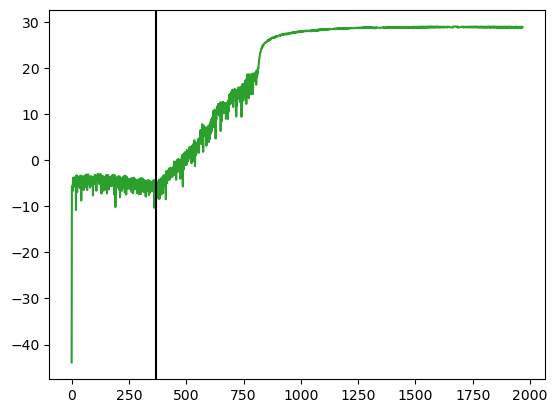

In [25]:
%matplotlib inline
plt.plot(np.log(np.abs(br.L_grad_history[:,5,...].reshape(-1,br.bw.mu.shape[1]**2))))
# plt.ylim([-.01,.01])
plt.axvline(switch_iteration - brs[0,0].bw.M, color='k')
